In [1]:
# --- Cell 1: Tải các thư viện ---
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
print(f"TensorFlow version: {tf.__version__}")

2025-11-22 09:22:37.913664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763803358.082132      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763803358.128987      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0


In [2]:
# --- Cell 2 (train.ipynb - SỬA LỖI CHO CSV): Tải dữ liệu đã xử lý ---
file_name = '/kaggle/input/kpi-processed/kpi_processed.csv' # <-- Đã đổi tên file
try:
    # *** THAY ĐỔI QUAN TRỌNG ***
    # Chúng ta dùng pd.read_csv và thêm 2 tham số:
    # 1. index_col=0: Báo cho Pandas rằng cột đầu tiên (cột 0) là index.
    # 2. parse_dates=True: Báo cho Pandas chuyển đổi index đó thành Datetime.
    df = pd.read_csv(file_name, index_col=0, parse_dates=True)
    
    print(f"Tải file '{file_name}' thành công.")
    print(f"Dữ liệu có {len(df)} hàng, kéo dài từ {df.index.min()} đến {df.index.max()}.")
    print("\nThông tin dữ liệu (df.info()):")
    df.info() 
    
except Exception as e:
    print(f"LỖI: Không thể tải file '{file_name}'.")
    print(e)

Tải file '/kaggle/input/kpi-processed/kpi_processed.csv' thành công.
Dữ liệu có 313186 hàng, kéo dài từ 2025-10-11 00:00:00 đến 2025-11-10 23:45:00.

Thông tin dữ liệu (df.info()):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313186 entries, 2025-10-11 00:00:00 to 2025-11-10 23:00:00
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   enodeb                  313186 non-null  object 
 1   cell_name               313186 non-null  object 
 2   ps_traffic_mb           313168 non-null  float64
 3   avg_rrc_connected_user  313186 non-null  float64
 4   prb_dl_used             312997 non-null  float64
 5   prb_dl_available_total  312997 non-null  float64
 6   prb_utilization         313186 non-null  float64
dtypes: float64(5), object(2)
memory usage: 19.1+ MB


In [3]:

# --- Cell 3: Xử lý dữ liệu (Quan trọng!) ---
# Mục tiêu: Đảm bảo MỌI cell_name đều có đầy đủ 15 phút, không bị ngắt quãng.
# Nếu thiếu, chúng ta sẽ lấp đầy bằng 0.
if 'df' in locals():
    # Xác định các cột KPI để dự đoán
    FEATURE_COLS = ['ps_traffic_mb', 'avg_rrc_connected_user', 'prb_dl_used', 'prb_dl_available_total', 'prb_utilization']
    N_FEATURES = len(FEATURE_COLS)
    print(f"Dự đoán {N_FEATURES} features: {FEATURE_COLS}")
    # Tạo ra một DataFrame đầy đủ cho MỌI cell
    print("Đang xử lý: Đảm bảo dữ liệu 15 phút đầy đủ cho mỗi cell...")
    # Lấy tất cả các cell độc nhất
    all_cells = df['cell_name'].unique()
    # Tạo ra một index thời gian 15 phút đầy đủ từ đầu đến cuối
    # (Sửa lỗi cảnh báo: '15T' -> '15min')
    full_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15min')
    # Tạo MultiIndex (cell_name, timestamp)
    multi_index = pd.MultiIndex.from_product([all_cells, full_time_index], names=['cell_name', 'timestamp'])
    # Lấy các cột dữ liệu
    df_data_only = df[FEATURE_COLS + ['cell_name']]
    # Đưa timestamp ra thành một cột
    df_data_only = df_data_only.reset_index()
    # Xử lý các (cell_name, timestamp) bị trùng lặp
    print(f"Dữ liệu trước khi xử lý trùng lặp: {len(df_data_only)} hàng")
    df_grouped_unique = df_data_only.groupby(['cell_name', 'timestamp']).mean()
    print(f"Dữ liệu sau khi xử lý trùng lặp (groupby.mean): {len(df_grouped_unique)} hàng")
    # Reindex với MultiIndex đầy đủ, điền 0 vào các chỗ thiếu
    df_full = df_grouped_unique.reindex(multi_index, fill_value=0)
    # *** (BƯỚC SỬA LỖI KEYERROR) ***
    # 1. Reset TẤT CẢ các cấp index ('cell_name', 'timestamp') ra thành cột
    df_full = df_full.reset_index() 
    # 2. Đặt cột 'timestamp' làm index mới.
    # 'cell_name' bây giờ sẽ tự động là một cột, chính xác như chúng ta muốn.
    df_full = df_full.set_index('timestamp')
    # *** (KẾT THÚC SỬA LỖI) ***
    print(f"Dữ liệu gốc có {len(df)} hàng.")
    print(f"Dữ liệu đã điền đầy đủ (sau reindex) có {len(df_full)} hàng.")
    print("Hoàn tất xử lý.")
    print("\n5 dòng đầu của dữ liệu đã xử lý đầy đủ:")
    print(df_full.head())
else:
    print("Lỗi: DataFrame 'df' không tồn tại. Vui lòng chạy lại Cell 2.")

Dự đoán 5 features: ['ps_traffic_mb', 'avg_rrc_connected_user', 'prb_dl_used', 'prb_dl_available_total', 'prb_utilization']
Đang xử lý: Đảm bảo dữ liệu 15 phút đầy đủ cho mỗi cell...
Dữ liệu trước khi xử lý trùng lặp: 313186 hàng
Dữ liệu sau khi xử lý trùng lặp (groupby.mean): 303370 hàng
Dữ liệu gốc có 313186 hàng.
Dữ liệu đã điền đầy đủ (sau reindex) có 321408 hàng.
Hoàn tất xử lý.

5 dòng đầu của dữ liệu đã xử lý đầy đủ:
                    cell_name  ps_traffic_mb  avg_rrc_connected_user  \
timestamp                                                              
2025-10-11 00:00:00  EnodebA3         161.14                8.527778   
2025-10-11 00:15:00  EnodebA3           0.00                0.000000   
2025-10-11 00:30:00  EnodebA3           0.00                0.000000   
2025-10-11 00:45:00  EnodebA3           0.00                0.000000   
2025-10-11 01:00:00  EnodebA3         231.61                7.777778   

                     prb_dl_used  prb_dl_available_total  prb_utili

In [4]:
# --- Cell 4: 
# Data của chúng ta có tần suất 15 phút (4 mẫu/giờ)
TIMESTEPS_PER_HOUR = 4
TIMESTEPS_PER_DAY = 24 * TIMESTEPS_PER_HOUR # 96
# (THAY ĐỔI QUAN TRỌNG TẠI ĐÂY) 
# Input: 2 ngày
INPUT_DAYS = 2
INPUT_STEPS = INPUT_DAYS * TIMESTEPS_PER_DAY # 2 * 96 = 192
# Output: 1 ngày
OUTPUT_DAYS = 1
OUTPUT_STEPS = OUTPUT_DAYS * TIMESTEPS_PER_DAY # 1 * 96 = 96
# *** (KẾT THÚC THAY ĐỔI) ***

# Yêu cầu dữ liệu tối thiểu = 192 + 96 = 276 steps (28 ngày)
print(f"Cấu hình mô hình: Input {INPUT_STEPS} bước (2 ngày), Output {OUTPUT_STEPS} bước (1 ngày).")
print(f"Yêu cầu dữ liệu tối thiểu cho 1 mẫu: 276 bước (28 ngày)")

# TÁCH DỮ LIỆU THEO THỜI GIAN (70/20/10)
if 'df_full' in locals():
    total_duration = df_full.index.max() - df_full.index.min()
    
    # 70% cho Train
    train_end_time = df_full.index.min() + total_duration * 0.7
    
    # Thêm 20% cho Validation (tổng 90%)
    val_end_time = df_full.index.min() + total_duration * 0.9
    
    # 10% còn lại cho Test

    print(f"\nMốc Train (70%):  Kết thúc lúc {train_end_time}")
    print(f"Mốc Val (20%):    Kết thúc lúc {val_end_time} (Bắt đầu từ {train_end_time})")
    print(f"Mốc Test (10%):   Bắt đầu từ  {val_end_time}")

    # Tách
    train_df = df_full[df_full.index < train_end_time]
    val_df = df_full[(df_full.index >= train_end_time) & (df_full.index < val_end_time)]
    test_df = df_full[df_full.index >= val_end_time]
    
    print(f"\nKích thước tập Train: {train_df.shape}")
    print(f"Kích thước tập Val:   {val_df.shape}")
    print(f"Kích thước tập Test:  {test_df.shape}")
else:
    print("Lỗi: DataFrame 'df_full' không tồn tại. Vui lòng chạy lại Cell 3.")

Cấu hình mô hình: Input 192 bước (2 ngày), Output 96 bước (1 ngày).
Yêu cầu dữ liệu tối thiểu cho 1 mẫu: 276 bước (28 ngày)

Mốc Train (70%):  Kết thúc lúc 2025-11-01 16:37:30
Mốc Val (20%):    Kết thúc lúc 2025-11-07 21:22:30 (Bắt đầu từ 2025-11-01 16:37:30)
Mốc Test (10%):   Bắt đầu từ  2025-11-07 21:22:30

Kích thước tập Train: (224964, 6)
Kích thước tập Val:   (64260, 6)
Kích thước tập Test:  (32184, 6)


In [5]:

# --- Cell 5: Chuẩn hóa (Scaling) Dữ liệu ---
# Chúng ta phải fit Scaler CHỈ trên dữ liệu train để tránh rò rỉ dữ liệu

# Kiểm tra xem có NaN hay Inf trong train_df không
print("Kiểm tra dữ liệu bẩn:")
print("Số lượng NaN:", train_df.isna().sum().sum())
print("Số lượng Inf:", np.isinf(train_df[FEATURE_COLS].values).sum())

# Xử lý thay thế (nếu có)
train_df = train_df.replace([np.inf, -np.inf], 0)
train_df = train_df.fillna(0)

val_df = val_df.replace([np.inf, -np.inf], 0)
val_df = val_df.fillna(0)

test_df = test_df.replace([np.inf, -np.inf], 0)
test_df = test_df.fillna(0)

print("Đã làm sạch dữ liệu NaN/Inf.")
if 'train_df' in locals():
    # Khởi tạo Scaler
    scaler = MinMaxScaler()
    
    # 1. Fit scaler CHỈ trên dữ liệu train (chỉ các cột features)
    # Chúng ta phải fit trên toàn bộ dữ liệu train để scaler học được min/max
    scaler.fit(train_df[FEATURE_COLS])
    
    # 2. Transform cả 3 tập
    # Lưu lại 'cell_name' để dùng cho việc nhóm
    train_cells = train_df['cell_name']
    val_cells = val_df['cell_name']
    test_cells = test_df['cell_name']

    # Transform
    train_scaled_data = scaler.transform(train_df[FEATURE_COLS])
    val_scaled_data = scaler.transform(val_df[FEATURE_COLS])
    test_scaled_data = scaler.transform(test_df[FEATURE_COLS])
    
    # 3. Tạo lại DataFrame đã scale (việc này giúp nhóm dễ dàng hơn)
    scaled_train_df = pd.DataFrame(train_scaled_data, columns=FEATURE_COLS, index=train_df.index)
    scaled_train_df['cell_name'] = train_cells

    scaled_val_df = pd.DataFrame(val_scaled_data, columns=FEATURE_COLS, index=val_df.index)
    scaled_val_df['cell_name'] = val_cells

    scaled_test_df = pd.DataFrame(test_scaled_data, columns=FEATURE_COLS, index=test_df.index)
    scaled_test_df['cell_name'] = test_cells
    
    print("Hoàn tất scaling dữ liệu.")
    print("Dữ liệu train sau khi scale (5 dòng đầu):")
    print(scaled_train_df.head())

# %%

Kiểm tra dữ liệu bẩn:
Số lượng NaN: 145
Số lượng Inf: 0
Đã làm sạch dữ liệu NaN/Inf.
Hoàn tất scaling dữ liệu.
Dữ liệu train sau khi scale (5 dòng đầu):
                     ps_traffic_mb  avg_rrc_connected_user  prb_dl_used  \
timestamp                                                                 
2025-10-11 00:00:00       0.015048                0.020689     0.047368   
2025-10-11 00:15:00       0.000000                0.000000     0.000000   
2025-10-11 00:30:00       0.000000                0.000000     0.000000   
2025-10-11 00:45:00       0.000000                0.000000     0.000000   
2025-10-11 01:00:00       0.021629                0.018869     0.047368   

                     prb_dl_available_total  prb_utilization cell_name  
timestamp                                                               
2025-10-11 00:00:00                  0.9375         0.047368  EnodebA3  
2025-10-11 00:15:00                  0.0000         0.000000  EnodebA3  
2025-10-11 00:30:00          

In [6]:

# --- Cell 6: Hàm tạo cửa sổ (Windowing) ---
# Đây là hàm quan trọng nhất:
# Nó sẽ duyệt qua TỪNG cell_name, sau đó tạo các cặp (X, y)
# X = 672 bước (7 ngày), y = 96 bước (1 ngày)

def create_windows(data_df, input_steps, output_steps, feature_cols):
    """
    Tạo các cửa sổ X (input) và y (output) từ dữ liệu đã scale,
    nhóm theo 'cell_name'.
    """
    X, y = [], []
    
    # Nhóm dữ liệu theo từng cell
    grouped = data_df.groupby('cell_name')
    
    total_cells = len(grouped)
    print(f"Bắt đầu tạo cửa sổ cho {total_cells} cell...")
    
    cell_count = 0
    for cell_id, cell_data in grouped:
        cell_count += 1
        if cell_count % 50 == 0:
            print(f"  ...đang xử lý cell {cell_count}/{total_cells} (ID: {cell_id})")
            
        # Lấy dữ liệu số của cell này
        cell_features = cell_data[feature_cols].values
        
        # Tổng số mẫu của cell này
        total_samples = len(cell_features)
        
        # Tổng độ dài cần thiết cho 1 cửa sổ
        total_window_len = input_steps + output_steps
        
        # Trượt cửa sổ
        for i in range(total_samples - total_window_len + 1):
            # i là điểm bắt đầu của input
            input_start = i
            input_end = i + input_steps
            
            # output_end là điểm kết thúc của output
            output_end = input_end + output_steps
            
            # Lấy cửa sổ X và y
            window_X = cell_features[input_start:input_end, :]
            window_y = cell_features[input_end:output_end, :]
            
            X.append(window_X)
            y.append(window_y)
            
    print(f"Hoàn tất tạo cửa sổ. Đã tạo {len(X)} mẫu.")
    
    # Chuyển list thành Numpy array
    return np.array(X), np.array(y)

# %%

In [7]:
# --- Cell 7: Áp dụng hàm Windowing ---

if 'scaled_train_df' in locals():
    print("--- Đang tạo mẫu Train (X_train, y_train) ---")
    X_train, y_train = create_windows(scaled_train_df, INPUT_STEPS, OUTPUT_STEPS, FEATURE_COLS)
    
    print("\n--- Đang tạo mẫu Validation (X_val, y_val) ---")
    X_val, y_val = create_windows(scaled_val_df, INPUT_STEPS, OUTPUT_STEPS, FEATURE_COLS)
    
    print("\n--- Đang tạo mẫu Test (X_test, y_test) ---")
    X_test, y_test = create_windows(scaled_test_df, INPUT_STEPS, OUTPUT_STEPS, FEATURE_COLS)
    
    print("\n--- Kích thước dữ liệu (Shape) ---")
    print(f"X_train shape: {X_train.shape}") # (Số mẫu, 672, N_FEATURES)
    print(f"y_train shape: {y_train.shape}") # (Số mẫu, 96, N_FEATURES)
    print(f"X_val shape:   {X_val.shape}")
    print(f"y_val shape:   {y_val.shape}")
    print(f"X_test shape:  {X_test.shape}")
    print(f"y_test shape:  {y_test.shape}")
else:
    print("Lỗi: Dữ liệu đã scale không tồn tại. Vui lòng chạy lại Cell 5.")
    

--- Đang tạo mẫu Train (X_train, y_train) ---
Bắt đầu tạo cửa sổ cho 108 cell...
  ...đang xử lý cell 50/108 (ID: EnodebE2)
  ...đang xử lý cell 100/108 (ID: EnodebK1)
Hoàn tất tạo cửa sổ. Đã tạo 193968 mẫu.

--- Đang tạo mẫu Validation (X_val, y_val) ---
Bắt đầu tạo cửa sổ cho 108 cell...
  ...đang xử lý cell 50/108 (ID: EnodebE2)
  ...đang xử lý cell 100/108 (ID: EnodebK1)
Hoàn tất tạo cửa sổ. Đã tạo 33264 mẫu.

--- Đang tạo mẫu Test (X_test, y_test) ---
Bắt đầu tạo cửa sổ cho 108 cell...
  ...đang xử lý cell 50/108 (ID: EnodebE2)
  ...đang xử lý cell 100/108 (ID: EnodebK1)
Hoàn tất tạo cửa sổ. Đã tạo 1188 mẫu.

--- Kích thước dữ liệu (Shape) ---
X_train shape: (193968, 192, 5)
y_train shape: (193968, 96, 5)
X_val shape:   (33264, 192, 5)
y_val shape:   (33264, 96, 5)
X_test shape:  (1188, 192, 5)
y_test shape:  (1188, 96, 5)


In [8]:
# --- Cell 8: Xây dựng mô hình Transformer (Time Series) ---

from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Khối Encoder của Transformer gồm:
    Multi-Head Attention + Normalization + Feed Forward
    """
    # 1. Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs # Residual Connection (Kết nối tắt)

    # 2. Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(input_shape, output_steps, output_features, 
                            head_size=256, num_heads=4, ff_dim=4, 
                            num_transformer_blocks=4, mlp_units=[128], 
                            dropout=0, mlp_dropout=0):
    
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # --- A. Feature Projection ---
    # Chiếu dữ liệu gốc (5 features) lên không gian lớn hơn để Attention hoạt động tốt
    # Giống như việc "nhúng" (embedding) trong NLP
    x = layers.Dense(head_size)(x) 

    # --- B. Transformer Encoder Blocks ---
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # --- C. Output Head (Decoder đơn giản hóa) ---
    # Lấy đặc trưng trung bình hoặc Flatten
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    
    # Các lớp Dense (MLP) để học mối quan hệ phi tuyến tính
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    # Lớp cuối cùng: Phải tạo ra (OUTPUT_STEPS * N_FEATURES) giá trị
    # Sau đó Reshape lại thành (96, 5)
    x = layers.Dense(output_steps * output_features)(x)
    outputs = layers.Reshape((output_steps, output_features))(x)

    model = keras.Model(inputs, outputs)
    return model

# --- Khởi tạo Model ---
if 'X_train' in locals():
    keras.backend.clear_session()
    
    # Cấu hình Transformer
    input_shape = (INPUT_STEPS, N_FEATURES) # (192, 5)
    
    model = build_transformer_model(
        input_shape=input_shape,
        output_steps=OUTPUT_STEPS,     # 96
        output_features=N_FEATURES,    # 5
        head_size=64,                  # Kích thước vector đặc trưng
        num_heads=4,                   # Số lượng đầu "chú ý" (càng nhiều càng soi kỹ)
        ff_dim=128,                    # Kích thước mạng Feed Forward bên trong
        num_transformer_blocks=2,      # Số lớp Transformer chồng lên nhau
        mlp_units=[128],               # Lớp Dense ở cuối
        dropout=0.1,                   # Chống overfitting
        mlp_dropout=0.1
    )

    # Dùng AdamW (Adam + Weight Decay) thường tốt hơn cho Transformer
    optimizer = keras.optimizers.Adam(learning_rate=1e-3) # Có thể dùng AdamW nếu TF > 2.10

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    
    print("--- Transformer Architecture ---")
    model.summary()
else:
    print("Lỗi: Thiếu dữ liệu X_train.")

I0000 00:00:1763803375.768638      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


--- Transformer Architecture ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 192, 64)   │        384 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 192, 64)   │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 192, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 192, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 192, 64)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 192, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 192, 128)  │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 192, 64)   │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 192, 64)   │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 192, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 192, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 192, 64)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 192, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 192, 128)  │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 192, 64)   │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 192, 64)   │          0 │ conv1d_3[0][0], 

 Total params: 253,408 (989.88 KB)

 Trainable params: 253,408 (989.88 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# --- Cell 9: Huấn luyện Transformer ---

if 'model' in locals():
    print("Bắt đầu huấn luyện Transformer...")
    
    # Transformer cần batch_size lớn hơn để ổn định gradient
    BATCH_SIZE = 128  # Có thể tăng lên 256 nếu dùng GPU Kaggle
    EPOCHS = 50       # Transformer học nhanh, có thể tăng epoch lên

    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        # Giảm learning rate nếu loss không giảm (giúp model hội tụ sâu hơn)
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
    ]

    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )
    
    print("Hoàn tất huấn luyện!")

Bắt đầu huấn luyện Transformer...
Epoch 1/50


I0000 00:00:1763803385.854887     111 service.cc:148] XLA service 0x7c3c700087e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763803385.855588     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763803386.738581     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


   6/1516 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - loss: 0.1726 - mae: 0.2539  

I0000 00:00:1763803396.372035     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1516/1516 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - loss: 0.0274 - mae: 0.0885 - val_loss: 0.0132 - val_mae: 0.0499 - learning_rate: 0.0010
Epoch 2/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 0.0135 - mae: 0.0521 - val_loss: 0.0126 - val_mae: 0.0495 - learning_rate: 0.0010
Epoch 3/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 0.0118 - mae: 0.0519 - val_loss: 0.0101 - val_mae: 0.0439 - learning_rate: 0.0010
Epoch 4/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 0.0107 - mae: 0.0503 - val_loss: 0.0099 - val_mae: 0.0452 - learning_rate: 0.0010
Epoch 5/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 0.0103 - mae: 0.0497 - val_loss: 0.0095 - val_mae: 0.0423 - learning_rate: 0.0010
Epoch 6/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - loss: 0.0101 - mae: 0.0493 - val_loss: 0.0092 - val_mae: 0.0436 - learning_rate: 0.0010
Epoch 7/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 0.0099 - mae: 0.0489 - val_loss: 0.0089 - val_mae: 0.0427 - learning_ra

In [10]:
# --- Cell 10: Lưu mô hình ---
model.save('transformer_model.h5')
print("Model saved to transformer_model.h5")

Model saved to transformer_model.h5


--- Đánh giá kết quả huấn luyện ---


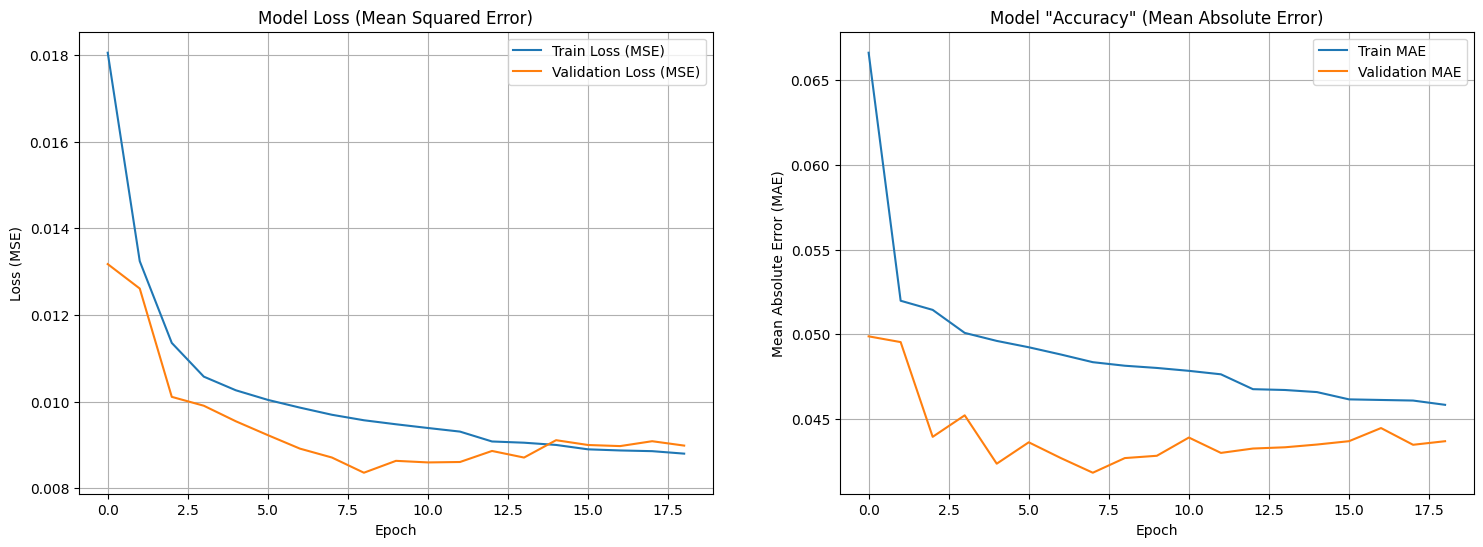


--- Đánh giá trên tập Test ---
  Test Loss (MSE): 0.008679
  Test MAE (Mean Absolute Error): 0.044303

Giải thích MAE:
Giá trị MAE = 0.044303 (trên dữ liệu đã scale từ 0-1).
Điều này có nghĩa là, trên thang 0-1, dự đoán của mô hình
sai lệch trung bình khoảng 0.044303 so với giá trị thực tế.
(Để có MAE theo đơn vị gốc (MB, Users...), chúng ta cần dùng scaler.inverse_transform)


In [11]:

# --- Cell 11: Đánh giá Loss và "Accuracy" ---

if 'history' in locals():
    print("--- Đánh giá kết quả huấn luyện ---")

    # 1. Trực quan hóa Loss (MSE) và MAE
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot Loss (MSE)
    ax1.plot(history.history['loss'], label='Train Loss (MSE)')
    ax1.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    ax1.set_title('Model Loss (Mean Squared Error)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot "Accuracy" (Chúng ta dùng MAE - Mean Absolute Error)
    # GHI CHÚ: "Accuracy" là metric cho bài toán Phân loại (Classification).
    # Đối với bài toán Hồi quy (Regression) như dự đoán KPI, 
    # chúng ta dùng MAE để đo "độ chính xác" (sai số tuyệt đối trung bình).
    
    ax2.plot(history.history['mae'], label='Train MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title('Model (Mean Absolute Error)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Absolute Error (MAE)')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

    # 2. Đánh giá trên tập TEST (Dữ liệu chưa từng thấy)
    print("\n--- Đánh giá trên tập Test ---")
    # model.evaluate sẽ trả về [loss, metric_1, metric_2, ...]
    # Tương ứng với compile(loss='mse', metrics=['mae'])
    test_results = model.evaluate(X_test, y_test, verbose=0)
    
    test_loss_mse = test_results[0]
    test_metric_mae = test_results[1]

    print(f"  Test Loss (MSE): {test_loss_mse:.6f}")
    print(f"  Test MAE (Mean Absolute Error): {test_metric_mae:.6f}")
    
    print("\nGiải thích MAE:")
    print(f"Giá trị MAE = {test_metric_mae:.6f} (trên dữ liệu đã scale từ 0-1).")
    print("Điều này có nghĩa là, trên thang 0-1, dự đoán của mô hình")
    print(f"sai lệch trung bình khoảng {test_metric_mae:.6f} so với giá trị thực tế.")
    print("(Để có MAE theo đơn vị gốc (MB, Users...), chúng ta cần dùng scaler.inverse_transform)")
    
else:
    print("Lỗi: Biến 'history' không tồn tại. Mô hình chưa được huấn luyện.")

--- Trực quan hóa kết quả dự đoán trên tập Test ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

--- So sánh Mẫu #1 ---


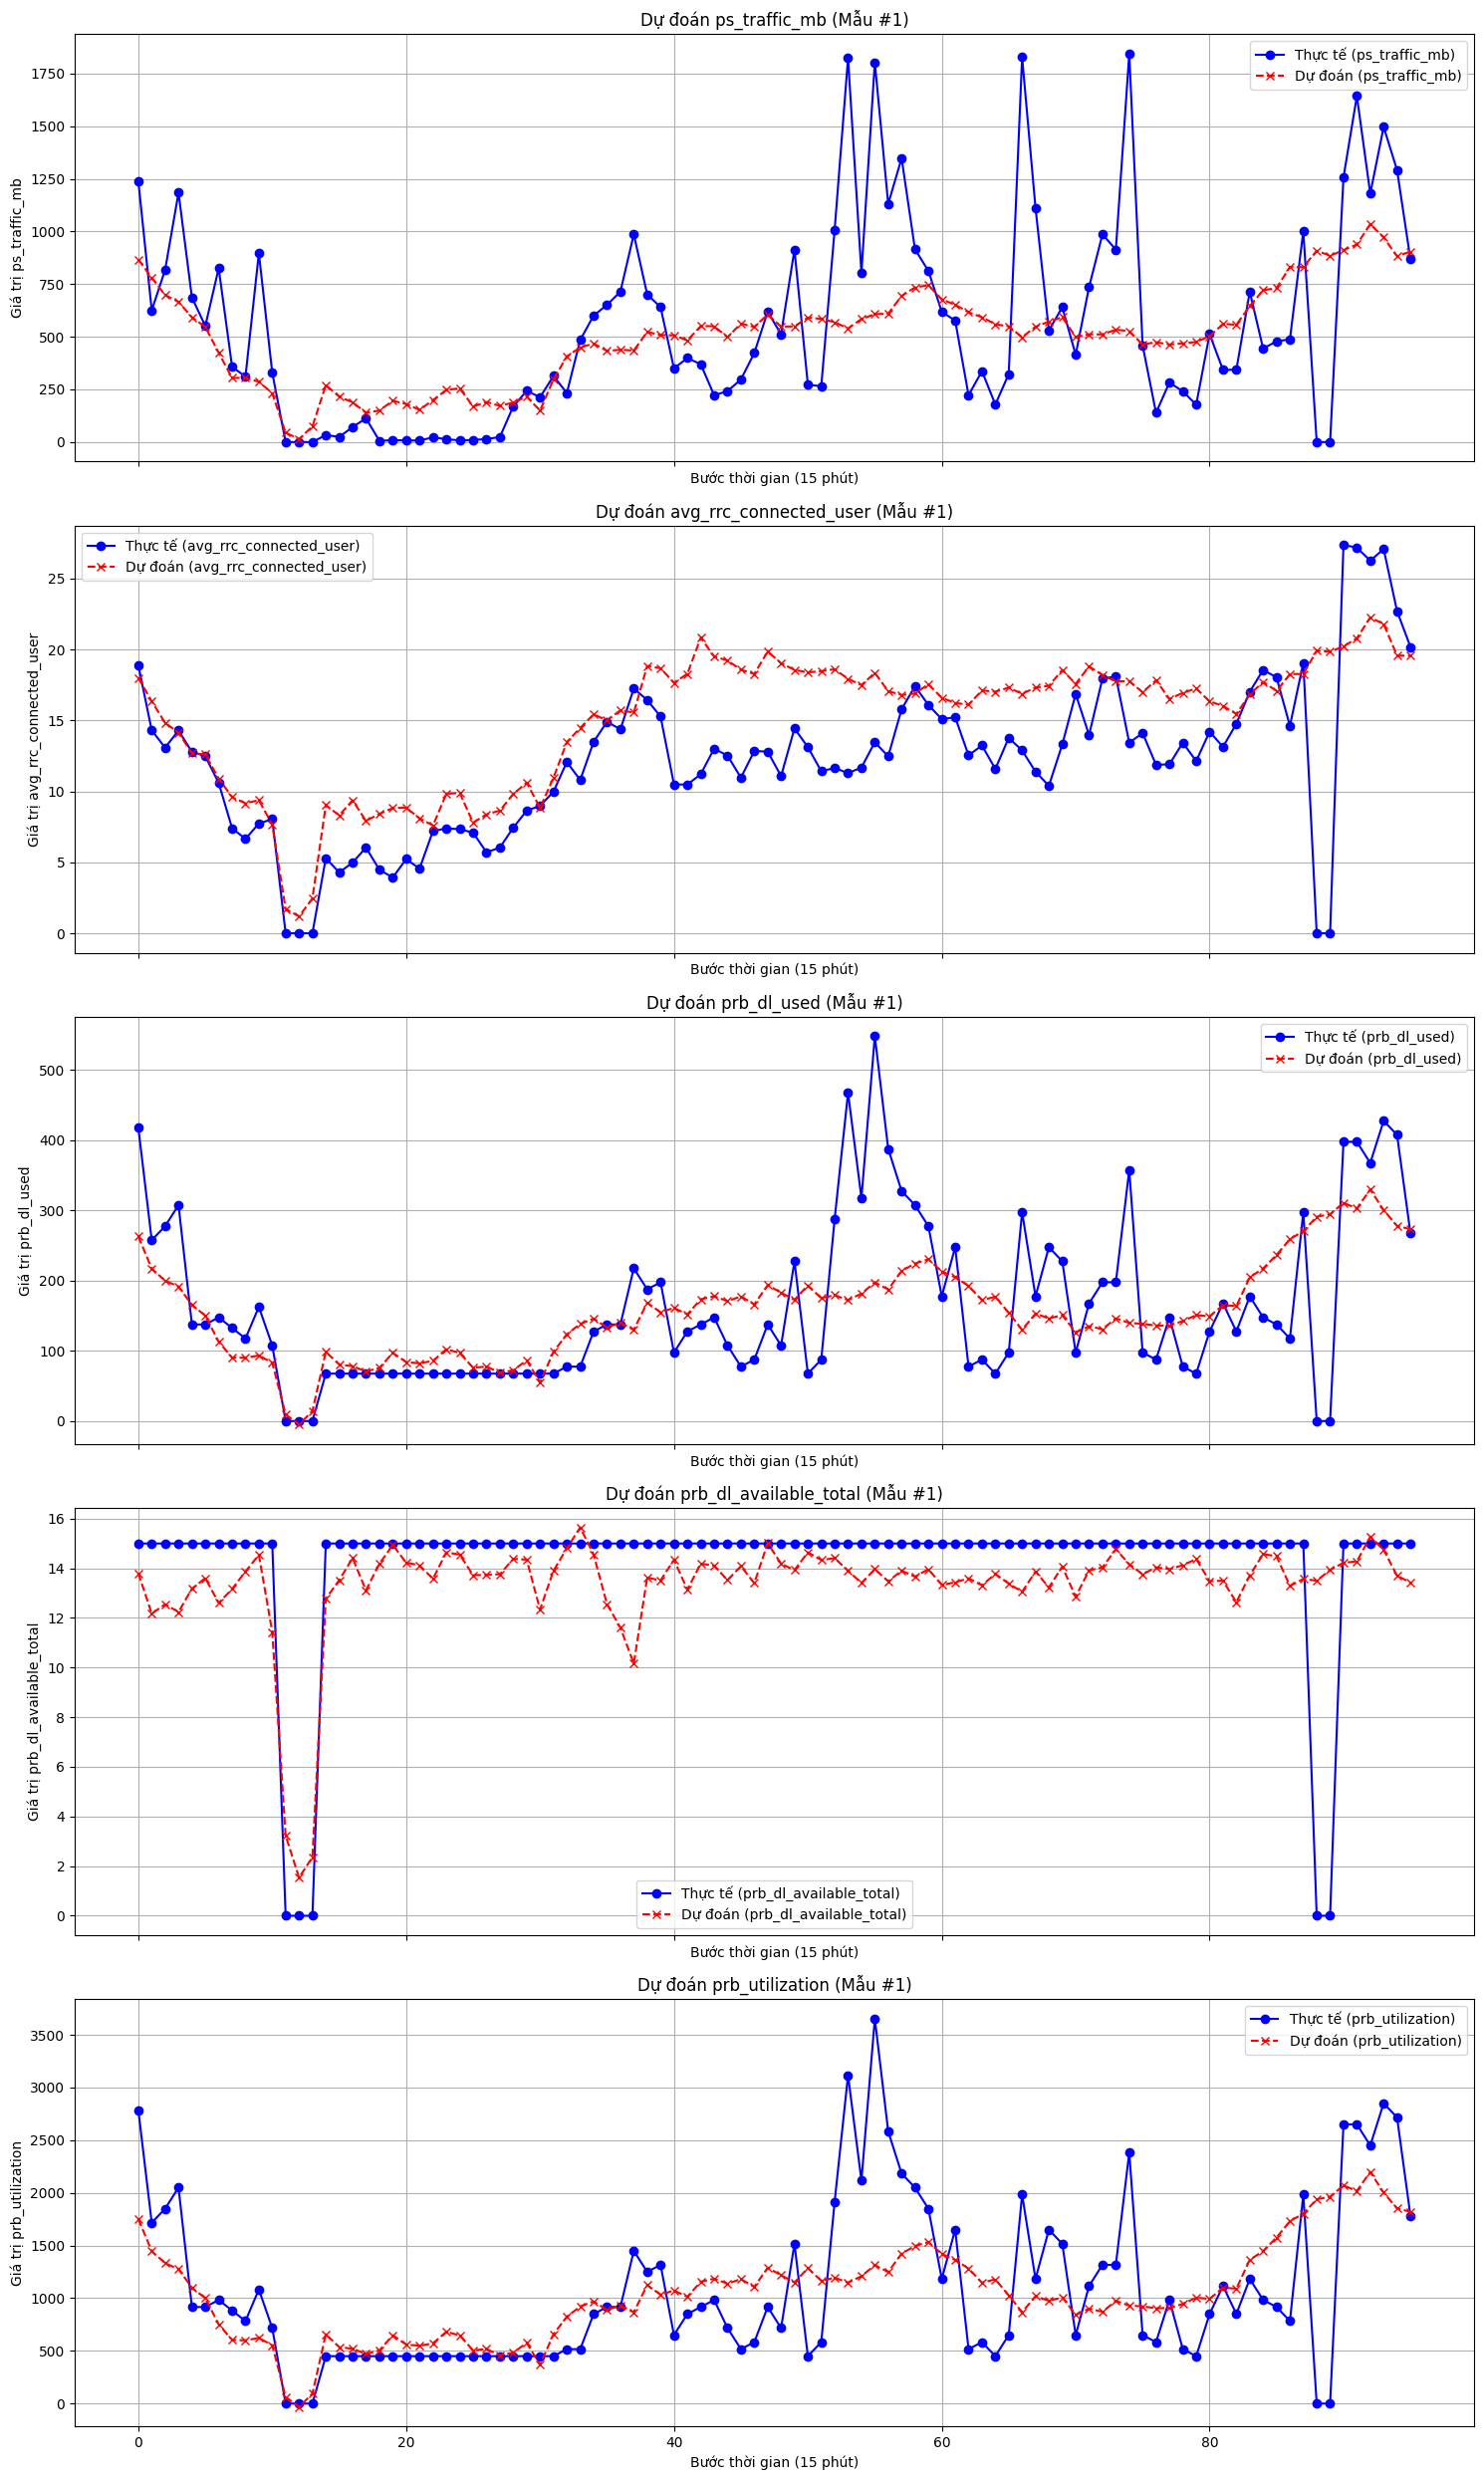


--- So sánh Mẫu #2 ---


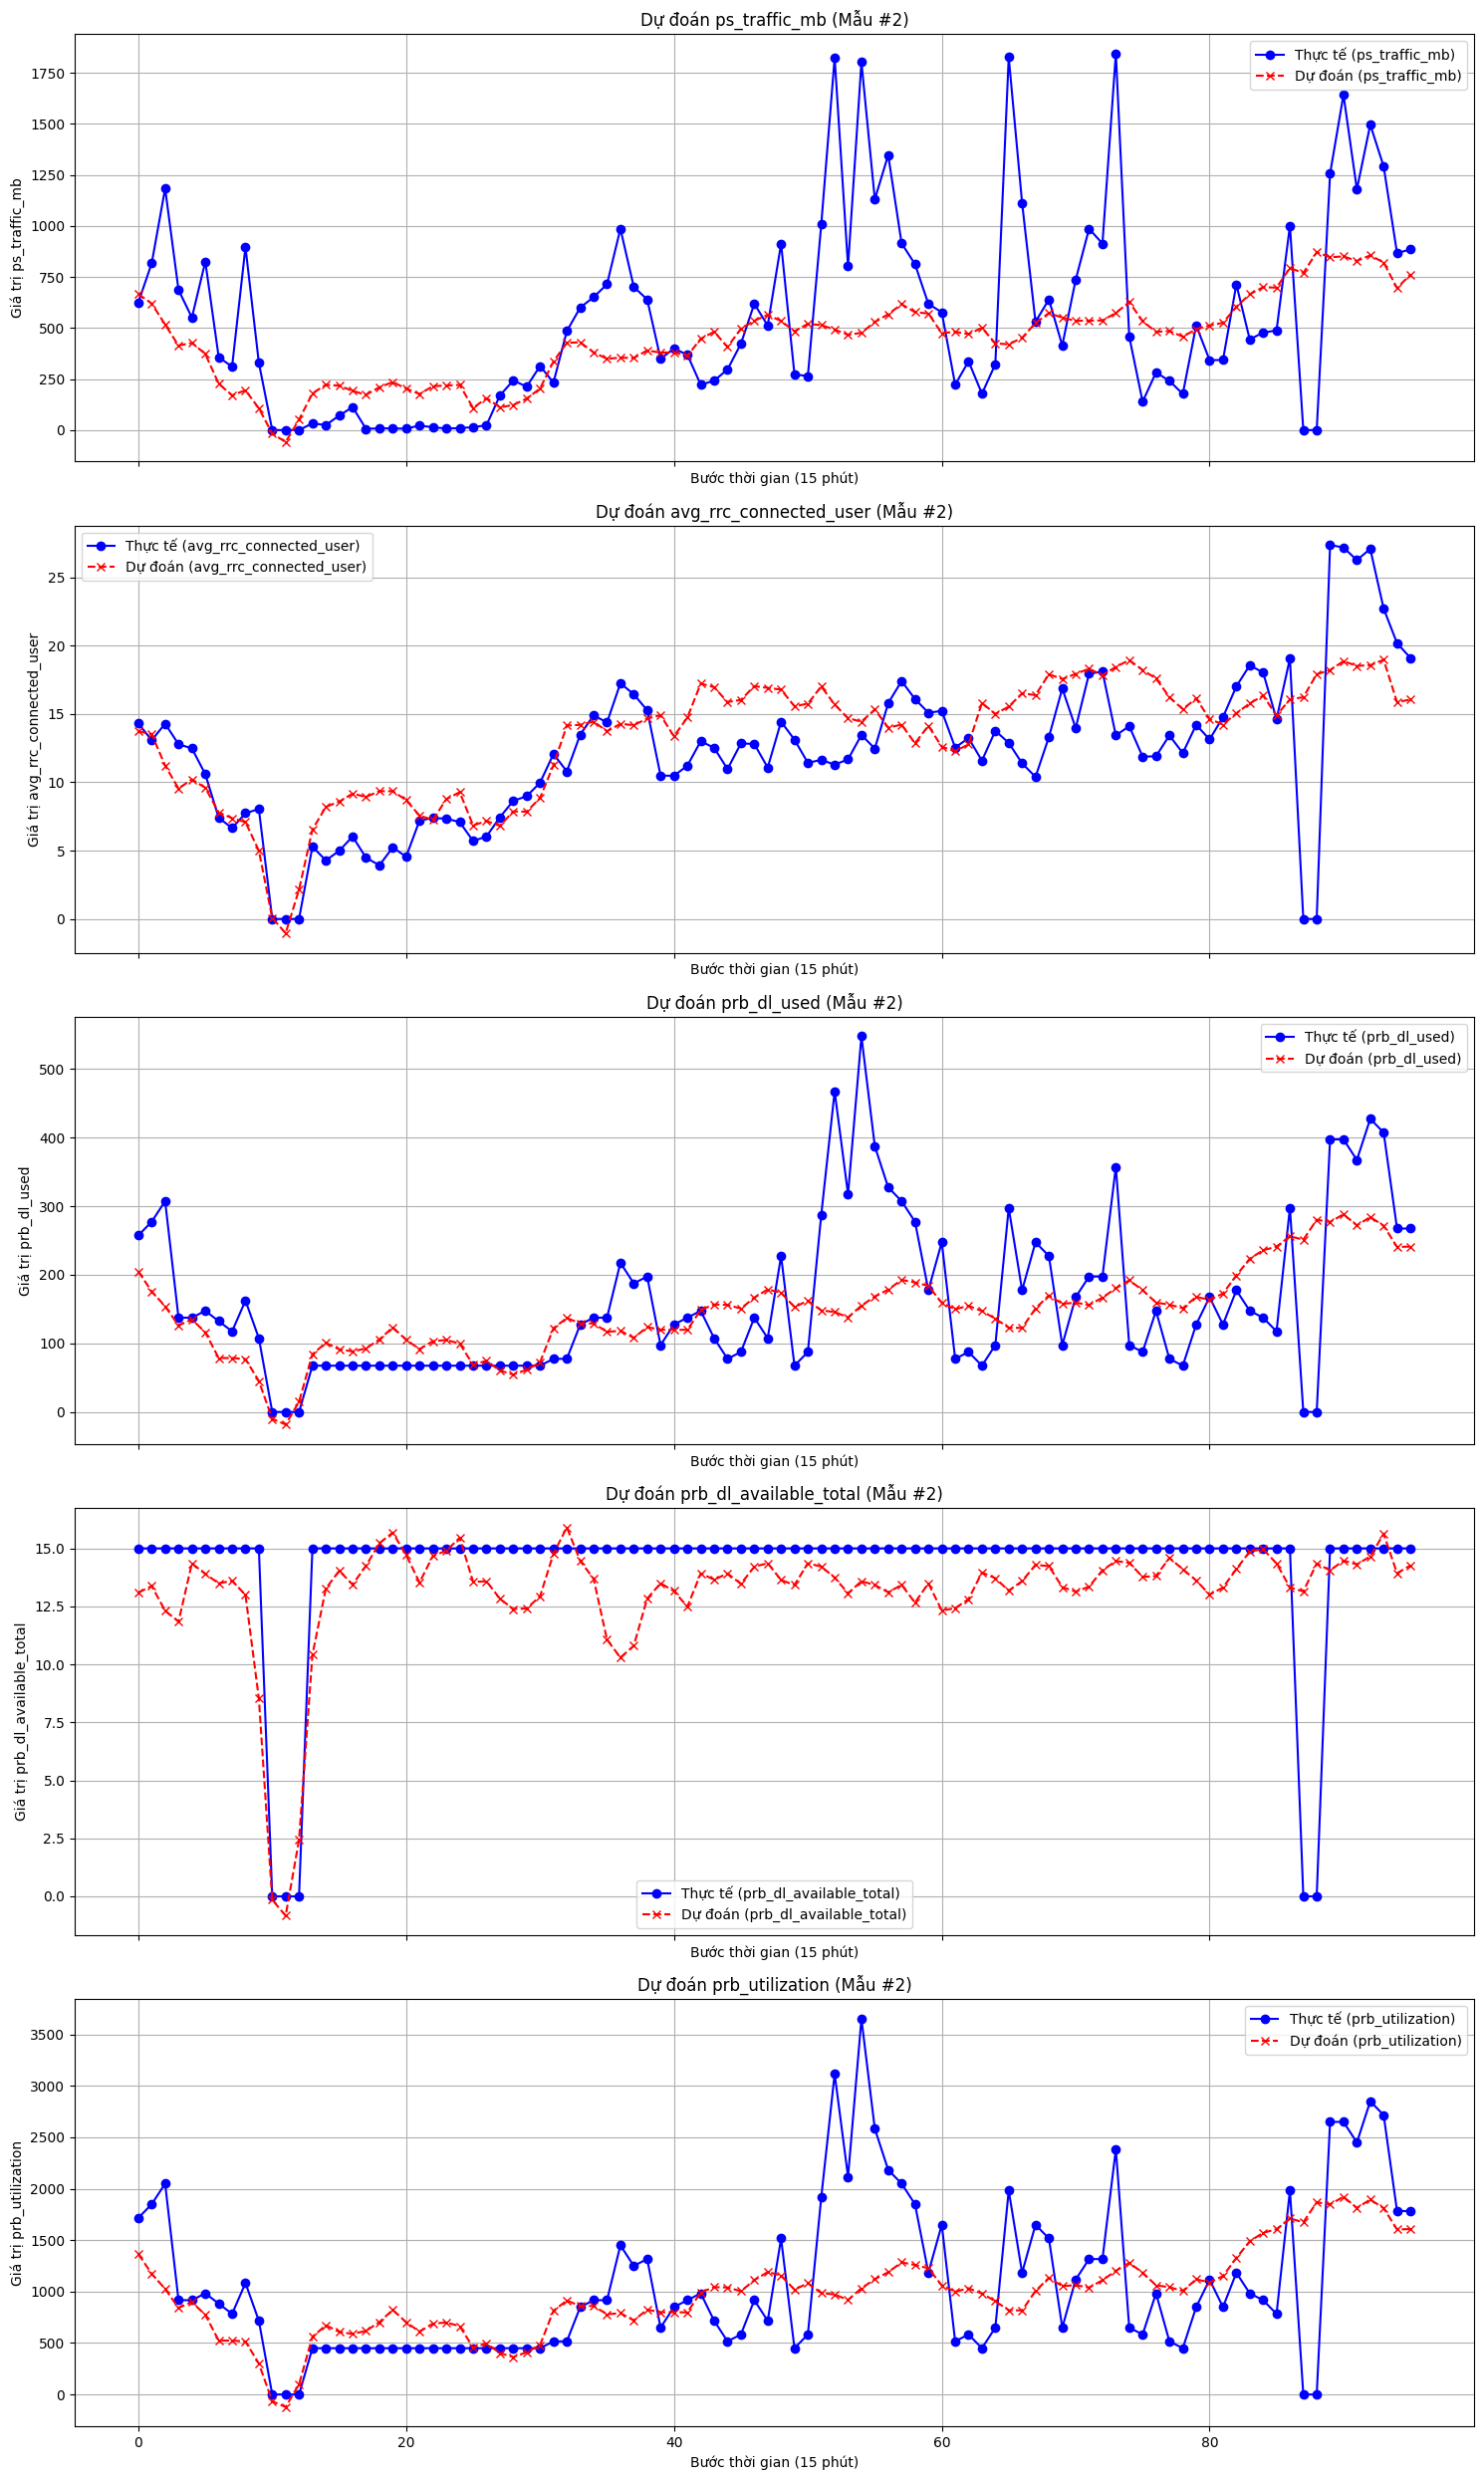


--- So sánh Mẫu #3 ---


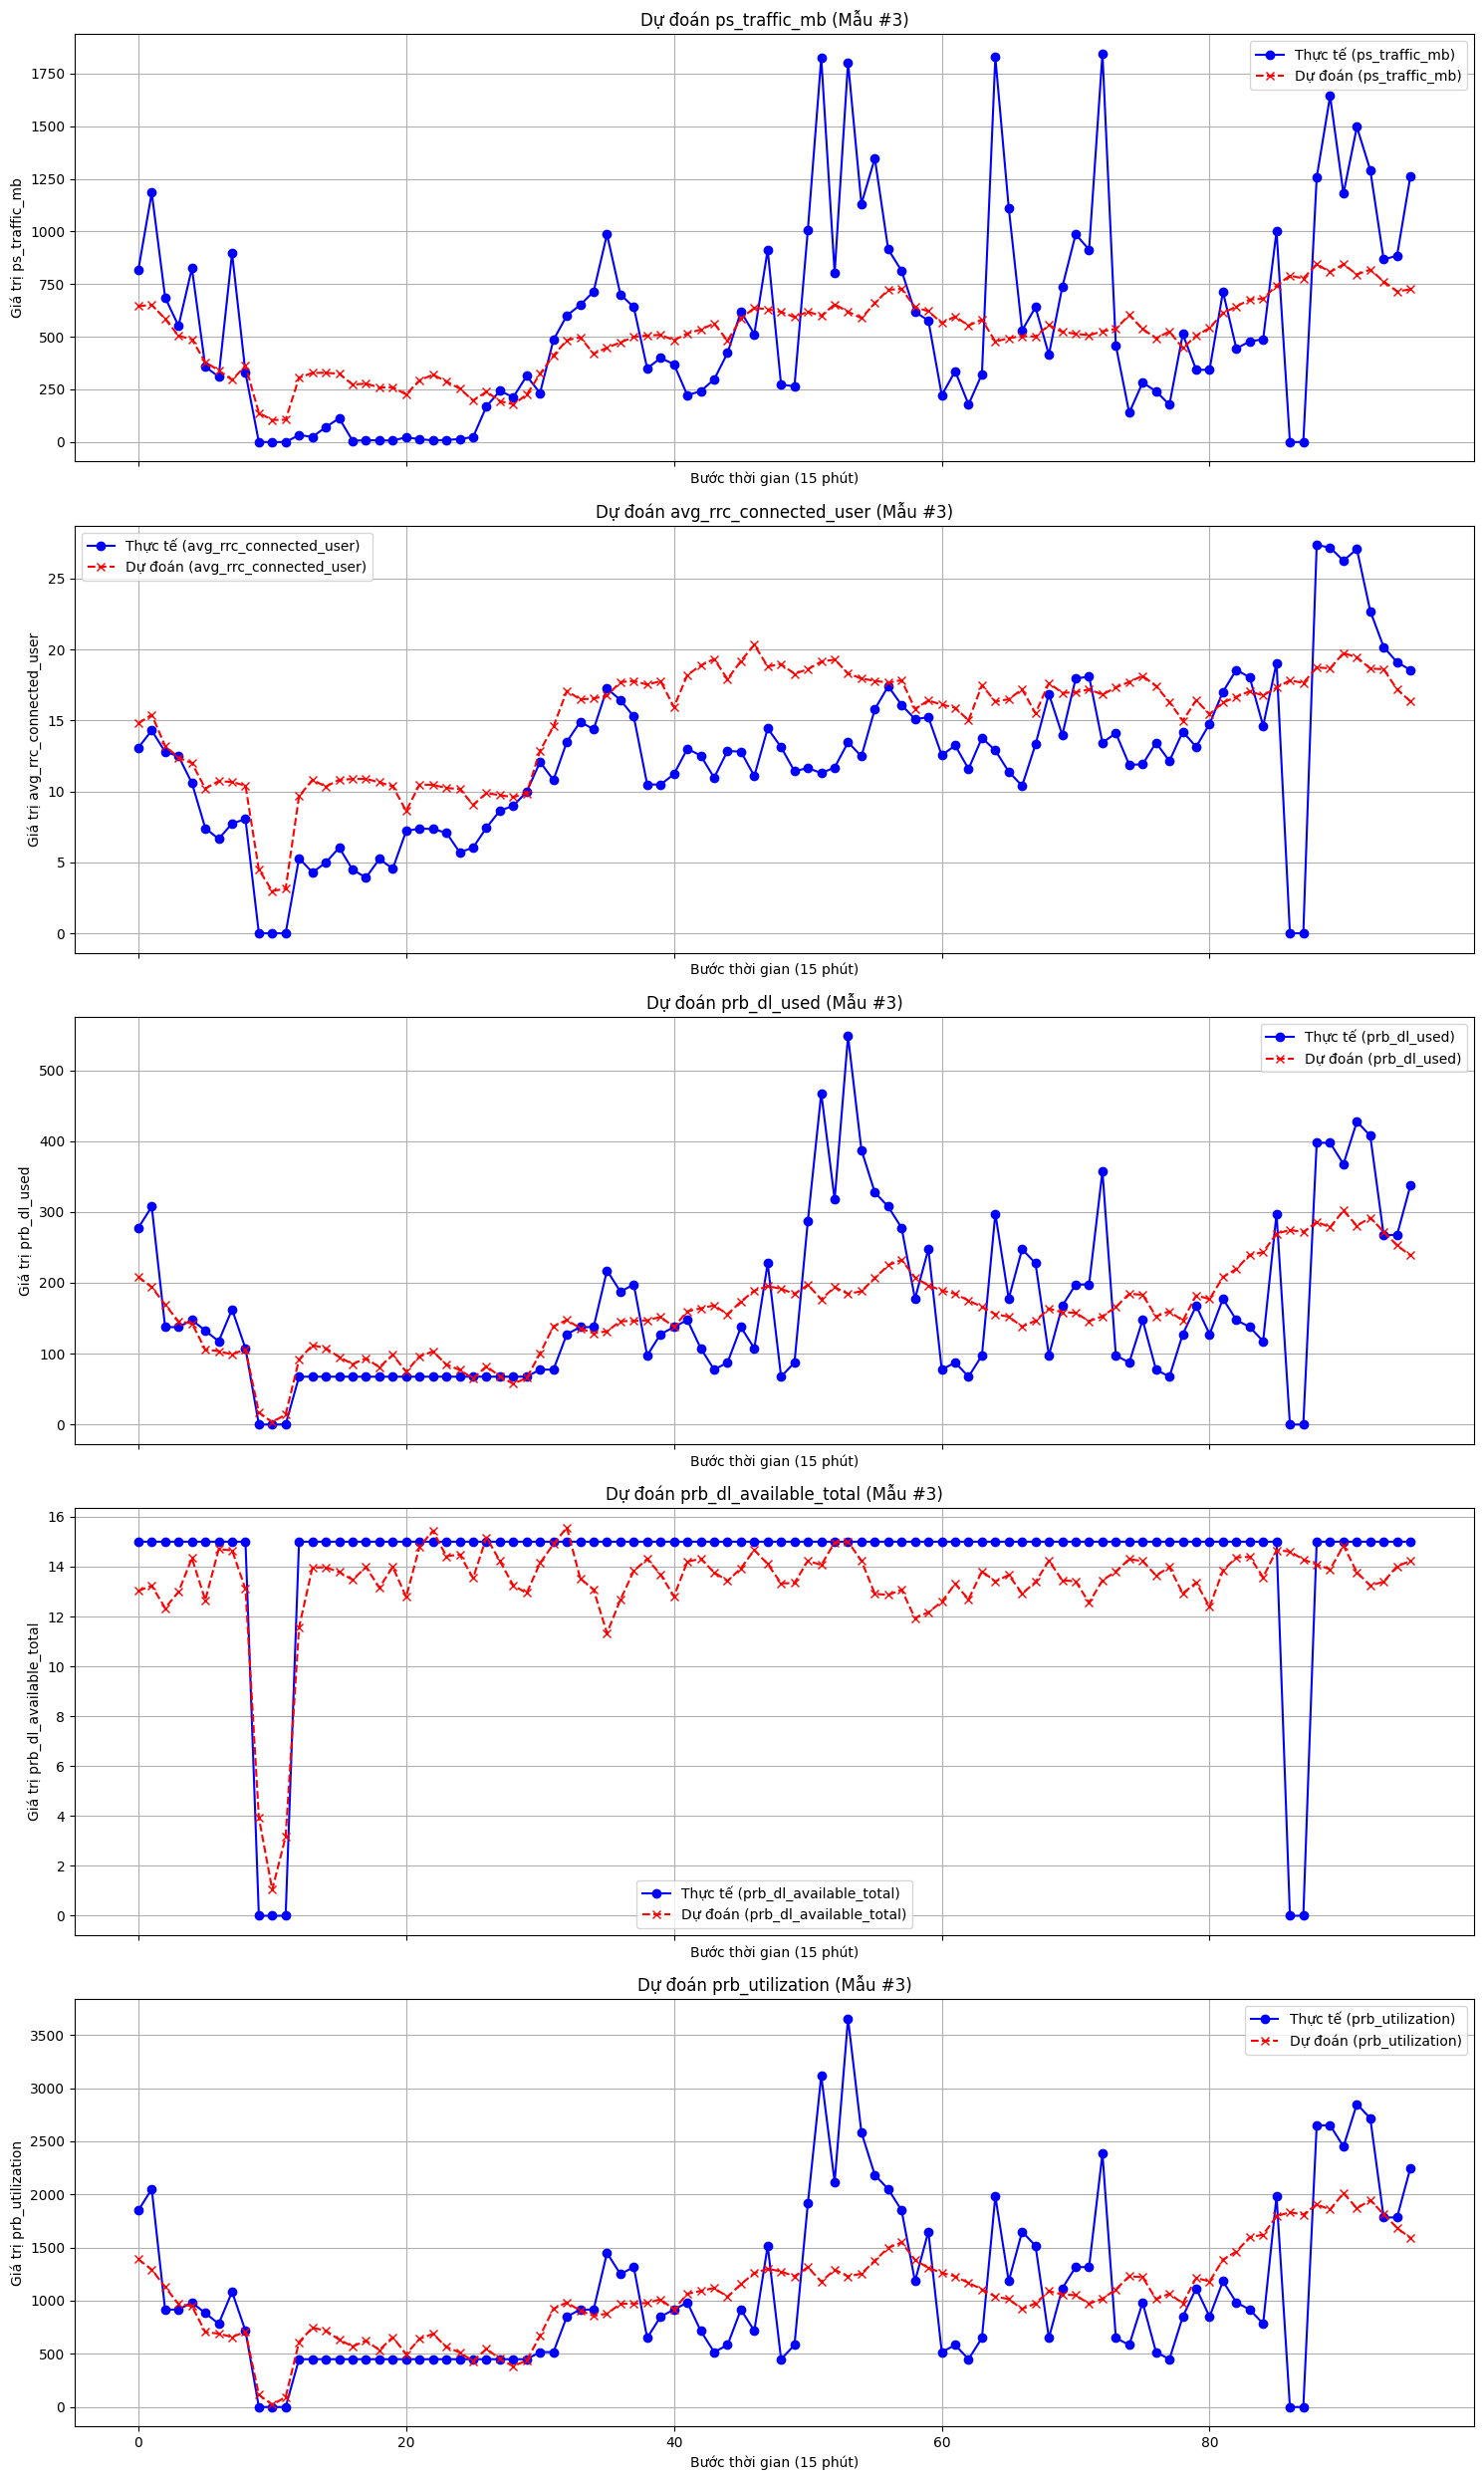


--- So sánh Mẫu #4 ---


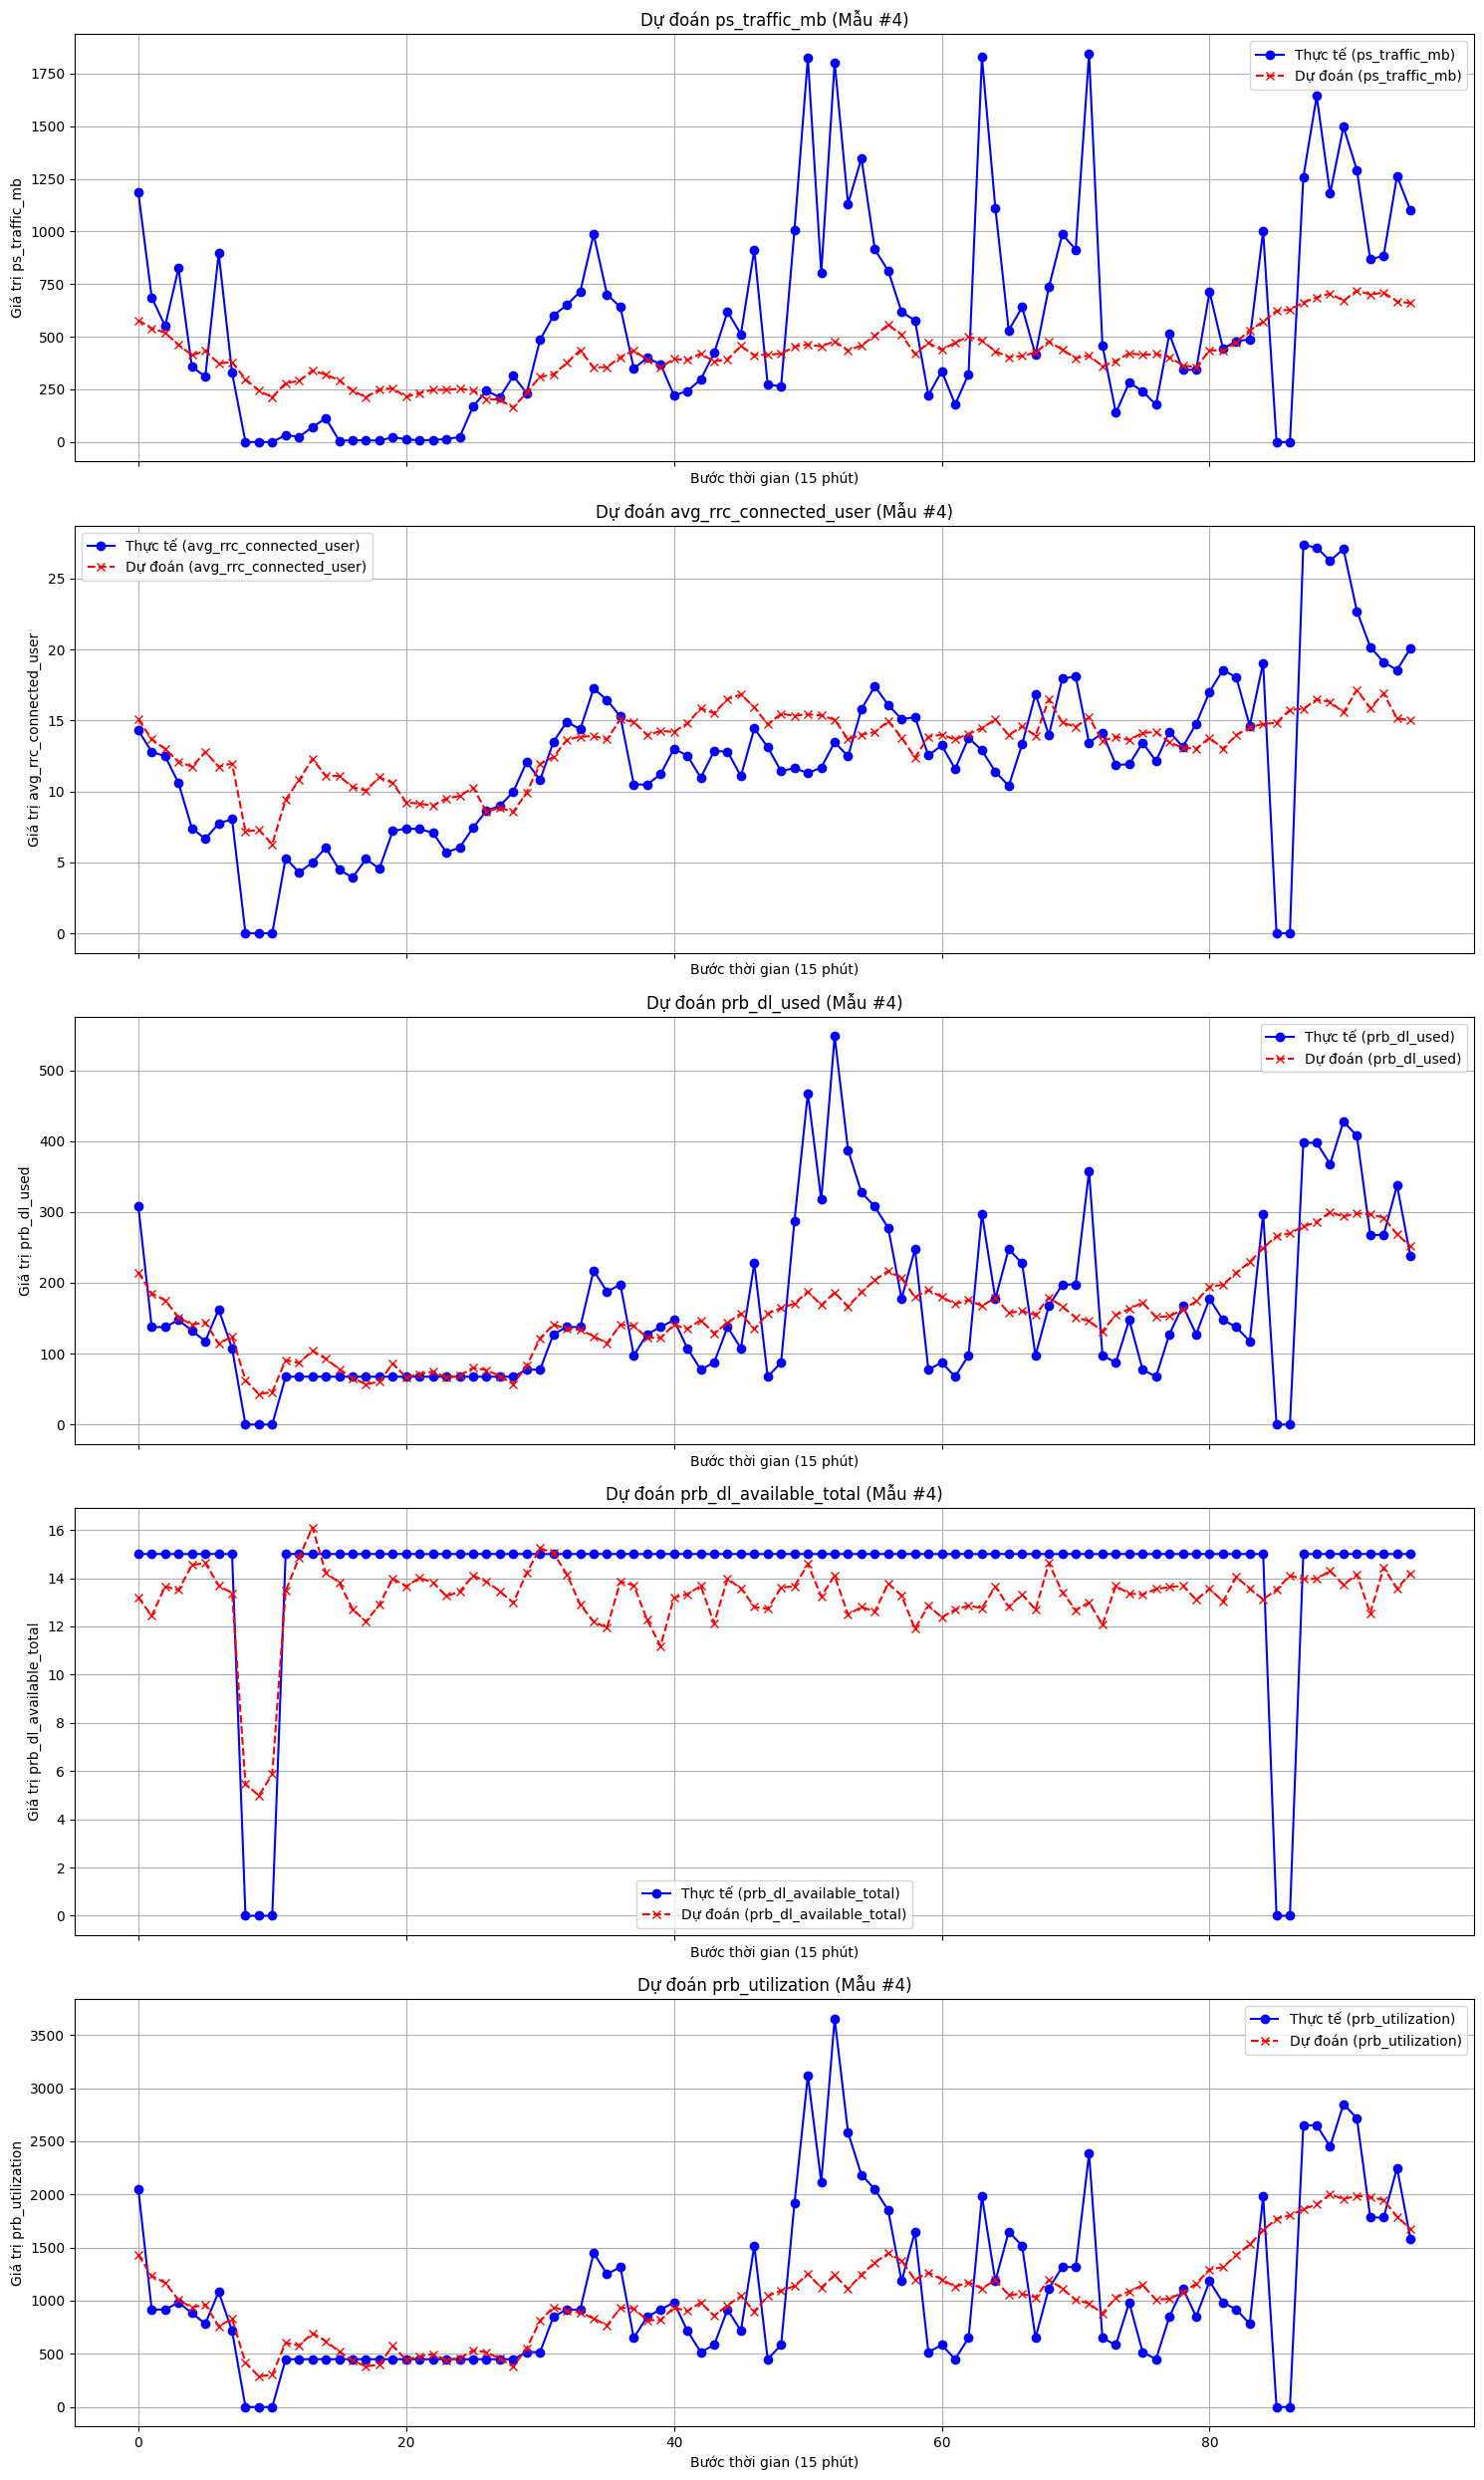


--- So sánh Mẫu #5 ---


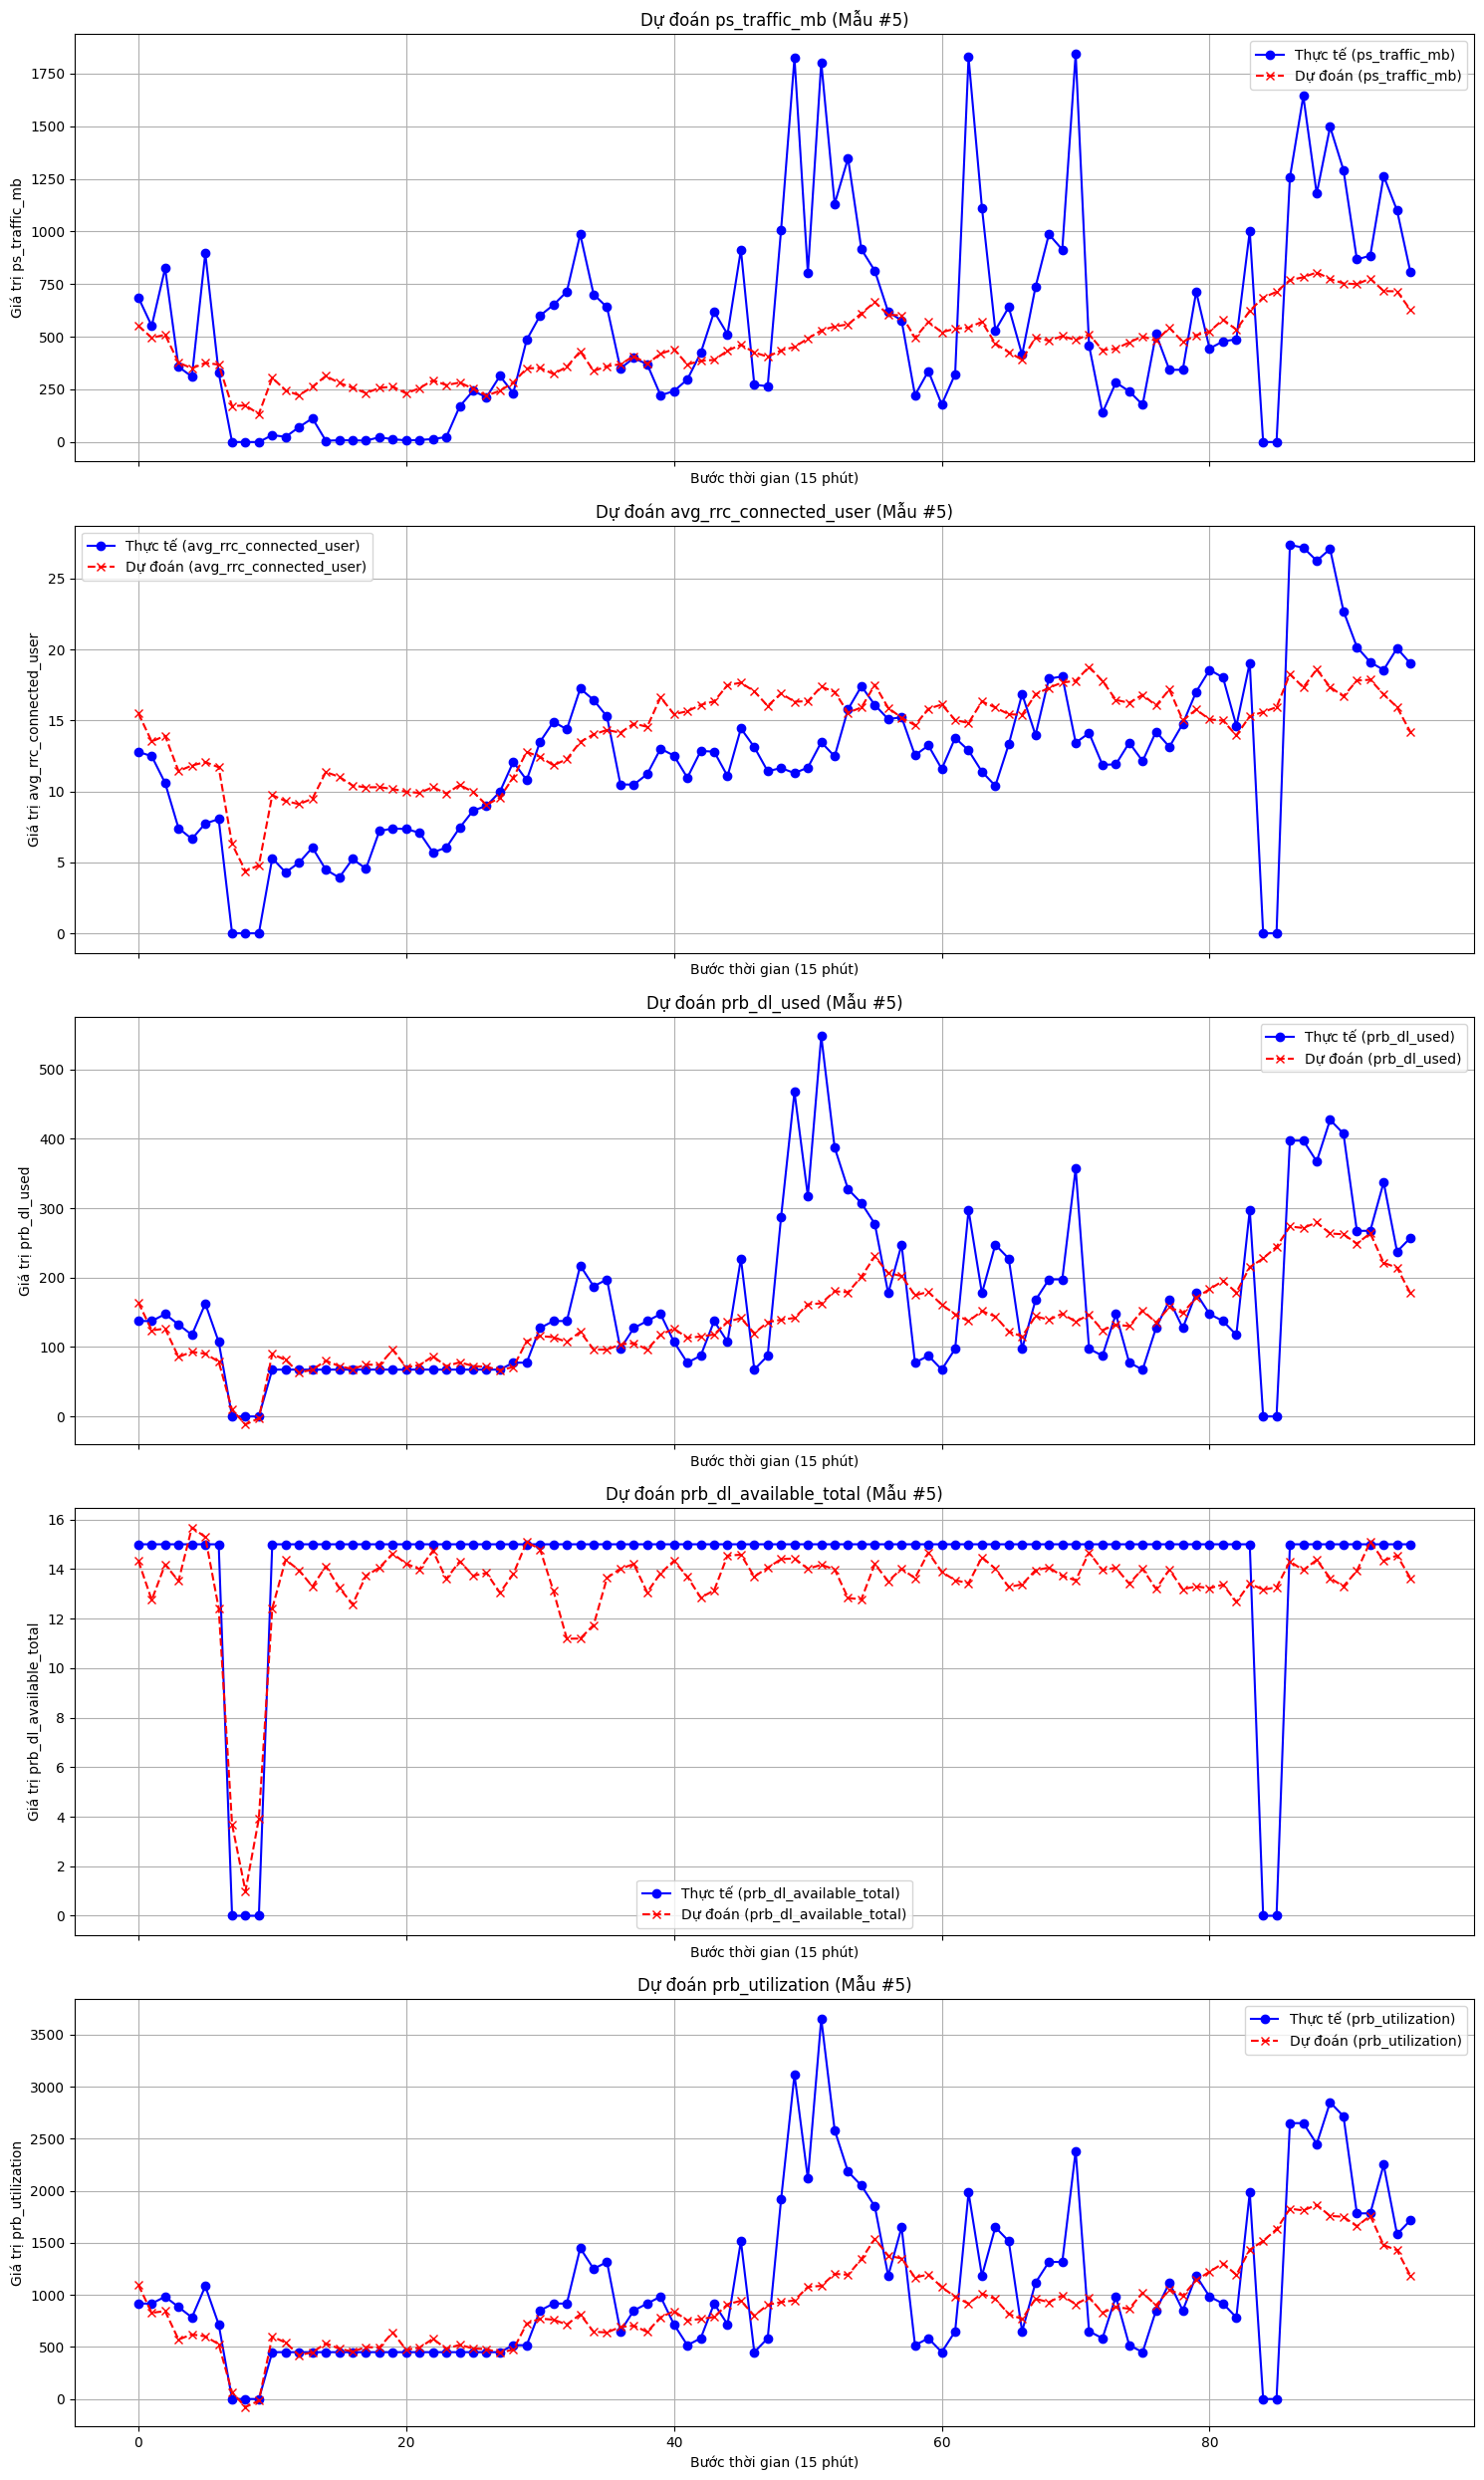


Hoàn tất trực quan hóa.


In [12]:
# --- Cell 12: So sánh kết quả dự đoán với giá trị thực tế ---

if 'model' in locals() and 'X_test' in locals() and 'y_test' in locals() and 'scaler' in locals():
    print("--- Trực quan hóa kết quả dự đoán trên tập Test ---")

    # 1. Dự đoán trên tập Test
    # Chọn một batch từ X_test để dự đoán
    # (Để đơn giản, ta lấy một vài mẫu đầu tiên hoặc một mẫu ngẫu nhiên)
    num_samples_to_plot = min(5, X_test.shape[0]) # Vẽ 5 mẫu hoặc ít hơn nếu X_test ít hơn

    if num_samples_to_plot == 0:
        print("Không có mẫu nào trong X_test để dự đoán và trực quan hóa.")
    else:
        # Lấy các mẫu đầu tiên từ X_test và y_test
        X_test_subset = X_test[:num_samples_to_plot]
        y_test_subset = y_test[:num_samples_to_plot]

        # Thực hiện dự đoán
        y_pred_scaled = model.predict(X_test_subset)

        # Đảo ngược quá trình chuẩn hóa (Inverse Scaling) cho cả giá trị thực và dự đoán
        # Chúng ta cần reshape lại dữ liệu thành 2D trước khi inverse_transform
        
        # Reshape y_test_subset (batch_size, output_steps, n_features) -> (batch_size * output_steps, n_features)
        y_true_reshaped = y_test_subset.reshape(-1, N_FEATURES)
        y_true_original = scaler.inverse_transform(y_true_reshaped)
        y_true_original = y_true_original.reshape(num_samples_to_plot, OUTPUT_STEPS, N_FEATURES)

        # Reshape y_pred_scaled (batch_size, output_steps, n_features) -> (batch_size * output_steps, n_features)
        y_pred_reshaped = y_pred_scaled.reshape(-1, N_FEATURES)
        y_pred_original = scaler.inverse_transform(y_pred_reshaped)
        y_pred_original = y_pred_original.reshape(num_samples_to_plot, OUTPUT_STEPS, N_FEATURES)

        # 2. Vẽ biểu đồ so sánh cho từng mẫu
        for i in range(num_samples_to_plot):
            print(f"\n--- So sánh Mẫu #{i+1} ---")
            
            fig, axes = plt.subplots(N_FEATURES, 1, figsize=(15, 5 * N_FEATURES), sharex=True)
            if N_FEATURES == 1: # Xử lý trường hợp chỉ có 1 feature (axes sẽ không phải mảng)
                axes = [axes]

            for j, feature_name in enumerate(FEATURE_COLS):
                ax = axes[j]
                ax.plot(y_true_original[i, :, j], label=f'Thực tế ({feature_name})', color='blue', marker='o', linestyle='-')
                ax.plot(y_pred_original[i, :, j], label=f'Dự đoán ({feature_name})', color='red', marker='x', linestyle='--')
                ax.set_title(f'Dự đoán {feature_name} (Mẫu #{i+1})')
                ax.set_xlabel('Bước thời gian (15 phút)')
                ax.set_ylabel(f'Giá trị {feature_name}')
                ax.legend()
                ax.grid(True)
            
            plt.tight_layout()
            plt.show()

        print("\nHoàn tất trực quan hóa.")

else:
    print("Lỗi: Không thể trực quan hóa. Đảm bảo 'model', 'X_test', 'y_test', 'scaler' đã tồn tại và X_test không rỗng.")